In [12]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional, Union, List
import pathlib
from dataclasses import dataclass
from enum import Enum
import time

In [13]:
class SegmentationMethod(Enum):
    BOUNDING_BOX = "bbox"
    HEIGHT_THRESHOLD = "height"
    SPHERICAL_REGION = "sphere"
    CYLINDRICAL_REGION = "cylinder"
    PLANAR_SLICE = "plane"

In [14]:
@dataclass
class SpatialRegion:
    x_range: Tuple[float, float]
    y_range: Tuple[float, float]
    z_range: Tuple[float, float]
    
    def contains(self, point: np.ndarray) -> bool:
        x, y, z = point
        return (self.x_range[0] <= x <= self.x_range[1] and
                self.y_range[0] <= y <= self.y_range[1] and
                self.z_range[0] <= z <= self.z_range[1])

In [15]:
@dataclass
class GeometricFilter:
    center: np.ndarray
    radius: float
    height_min: Optional[float] = None
    height_max: Optional[float] = None

In [16]:
class CloudSegmenter:
    
    def __init__(self, seed: int = 42):
        np.random.seed(seed)
    
    def generate_test_cloud(self, num_points: int = 100000,
                           bounds: Tuple[float, float] = (0, 100)) -> np.ndarray:
        low, high = bounds
        cloud = np.random.uniform(low, high, size=(num_points, 3))
        return cloud
    
    def extract_bounding_volume(self, points: np.ndarray,
                               region: SpatialRegion) -> np.ndarray:
        x_mask = (points[:, 0] >= region.x_range[0]) & (points[:, 0] <= region.x_range[1])
        y_mask = (points[:, 1] >= region.y_range[0]) & (points[:, 1] <= region.y_range[1])
        z_mask = (points[:, 2] >= region.z_range[0]) & (points[:, 2] <= region.z_range[1])
        
        volume_mask = x_mask & y_mask & z_mask
        return points[volume_mask]
    
    def extract_by_elevation(self, points: np.ndarray,
                            min_z: Optional[float] = None,
                            max_z: Optional[float] = None) -> np.ndarray:
        if min_z is not None and max_z is not None:
            mask = (points[:, 2] >= min_z) & (points[:, 2] <= max_z)
        elif min_z is not None:
            mask = points[:, 2] >= min_z
        elif max_z is not None:
            mask = points[:, 2] <= max_z
        else:
            return points.copy()
        
        return points[mask]
    
    def extract_spherical_region(self, points: np.ndarray,
                                center: np.ndarray,
                                radius: float) -> np.ndarray:
        # Векторизованное вычисление расстояний
        diff = points - center.reshape(1, -1)
        squared_distances = np.sum(diff * diff, axis=1)
        
        # Фильтрация точек внутри сферы
        spherical_mask = squared_distances <= (radius * radius)
        return points[spherical_mask]
    
    def extract_cylindrical_region(self, points: np.ndarray,
                                  center: np.ndarray,
                                  radius: float,
                                  min_z: float,
                                  max_z: float) -> np.ndarray:
        # Фильтрация по высоте
        z_mask = (points[:, 2] >= min_z) & (points[:, 2] <= max_z)
        
        # Фильтрация по горизонтальному расстоянию
        xy_center = center[:2]
        xy_points = points[:, :2]
        xy_diff = xy_points - xy_center.reshape(1, -1)
        xy_distances = np.sqrt(np.sum(xy_diff * xy_diff, axis=1))
        radius_mask = xy_distances <= radius
        
        # Комбинированная маска
        cylinder_mask = z_mask & radius_mask
        return points[cylinder_mask]
    
    def extract_planar_slice(self, points: np.ndarray,
                            normal: np.ndarray,
                            point_on_plane: np.ndarray,
                            thickness: float = 1.0) -> np.ndarray:
        # Нормализация вектора нормали
        normal_unit = normal / np.linalg.norm(normal)
        
        # Расстояние от каждой точки до плоскости
        distances = np.abs(np.dot(points - point_on_plane, normal_unit))
        
        # Фильтрация точек вблизи плоскости
        slice_mask = distances <= (thickness / 2)
        return points[slice_mask]
    
    def apply_multiple_filters(self, points: np.ndarray,
                              filters: List[callable]) -> np.ndarray:
        filtered_points = points.copy()
        for filter_func in filters:
            filtered_points = filter_func(filtered_points)
        return filtered_points

In [17]:
class CloudVisualizer:
    
    def __init__(self, figsize: Tuple[int, int] = (10, 8)):
        self.figsize = figsize
        self.colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                      '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                      '#bcbd22', '#17becf']
    
    def plot_3d_comparison(self, original: np.ndarray,
                          filtered: np.ndarray,
                          title: str = "Сравнение облаков",
                          filter_name: str = "Фильтр") -> None:
        fig = plt.figure(figsize=self.figsize)
        
        # Исходное облако
        ax1 = fig.add_subplot(121, projection='3d')
        self._plot_cloud(ax1, original, "Исходное облако")
        
        # Отфильтрованное облако
        ax2 = fig.add_subplot(122, projection='3d')
        self._plot_cloud(ax2, filtered, f"{filter_name}\n{filtered.shape[0]} точек")
        
        plt.suptitle(title, fontsize=14)
        plt.tight_layout()
        plt.show()
    
    def _plot_cloud(self, ax, points: np.ndarray, title: str) -> None:
        scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                           c=points[:, 2],  # Цвет по высоте
                           cmap='viridis',
                           s=1,
                           alpha=0.7,
                           edgecolors='none')
        
        ax.set_xlabel('X (м)', fontsize=9)
        ax.set_ylabel('Y (м)', fontsize=9)
        ax.set_zlabel('Z (м)', fontsize=9)
        ax.set_title(title, fontsize=11)
        ax.grid(True, alpha=0.3)
        
        # Добавление цветовой шкалы
        plt.colorbar(scatter, ax=ax, shrink=0.5, label='Высота (Z)')
    
    def plot_statistics(self, original: np.ndarray,
                       filtered_results: dict) -> None:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Получаем все методы и результаты
        methods = list(filtered_results.keys())
        
        # Статистика по количеству точек
        ax = axes[0, 0]
        counts = [len(res['points']) for res in filtered_results.values()]
        
        # Используем цикл для правильного подбора цветов
        bars = []
        for idx, (method, count) in enumerate(zip(methods, counts)):
            bar = ax.bar(idx, count, color=self.colors[idx % len(self.colors)])
            bars.append(bar[0])
        
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right')
        ax.set_title('Количество точек после фильтрации', fontsize=12)
        ax.set_ylabel('Количество точек', fontsize=10)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Добавление подписей к столбцам
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 50,
                   f'{count:,}', ha='center', va='bottom', fontsize=9)
        
        # Процент оставшихся точек
        ax = axes[0, 1]
        percentages = [(count / len(original)) * 100 for count in counts]
        ax.pie(percentages, labels=methods, autopct='%1.1f%%',
               colors=[self.colors[i % len(self.colors)] for i in range(len(methods))])
        ax.set_title('Доля точек после фильтрации', fontsize=12)
        
        # Распределение по высоте (Z)
        ax = axes[1, 0]
        for idx, (method, result) in enumerate(filtered_results.items()):
            points = result['points']
            if len(points) > 0:
                color_idx = idx % len(self.colors)
                ax.hist(points[:, 2], bins=30, alpha=0.6,
                       label=method, color=self.colors[color_idx])
        
        ax.set_title('Распределение по высоте', fontsize=12)
        ax.set_xlabel('Высота (Z)', fontsize=10)
        ax.set_ylabel('Частота', fontsize=10)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Время выполнения
        ax = axes[1, 1]
        times = [res['time'] for res in filtered_results.values()]
        
        bars_time = []
        for idx, (method, time_val) in enumerate(zip(methods, times)):
            bar = ax.bar(idx, time_val, color=self.colors[idx % len(self.colors)])
            bars_time.append(bar[0])
        
        ax.set_xticks(range(len(methods)))
        ax.set_xticklabels(methods, rotation=45, ha='right')
        ax.set_title('Время выполнения фильтрации', fontsize=12)
        ax.set_ylabel('Время (сек)', fontsize=10)
        ax.grid(True, axis='y', alpha=0.3)
        
        # Добавление подписей времени
        for bar, time_val in zip(bars_time, times):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{time_val:.4f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    
    def plot_filtered_regions(self, original: np.ndarray,
                             filtered_dict: dict) -> None:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # Исходное облако (полупрозрачное)
        ax.scatter(original[:, 0], original[:, 1], original[:, 2],
                  s=0.5, alpha=0.1, c='gray', label='Исходное')
        
        # Отфильтрованные области
        for idx, (method, result) in enumerate(filtered_dict.items()):
            points = result['points']
            if len(points) > 0:
                color_idx = idx % len(self.colors)
                ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                          s=2, alpha=0.7, color=self.colors[color_idx],
                          label=f'{method} ({len(points):,} точек)')
        
        ax.set_xlabel('X (м)', fontsize=10)
        ax.set_ylabel('Y (м)', fontsize=10)
        ax.set_zlabel('Z (м)', fontsize=10)
        ax.set_title('Все отфильтрованные области', fontsize=14)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

ДЕМОНСТРАЦИЯ СЕГМЕНТАЦИИ ОБЛАКОВ ТОЧЕК
Загрузка существующего облака...

Исходное облако содержит: 100,000 точек

1. Сегментация по ограничивающему объему:
   Выделено точек: 3,626
   Время выполнения: 0.0033 сек


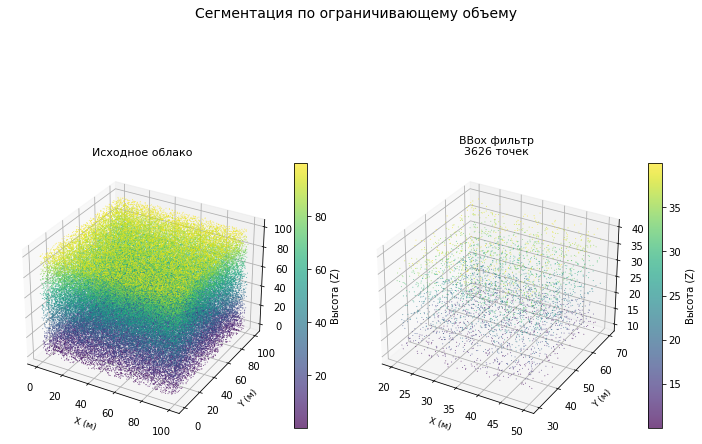


2. Выделение верхних точек:
   Точки выше 80м: 20,041
   Время выполнения: 0.0024 сек


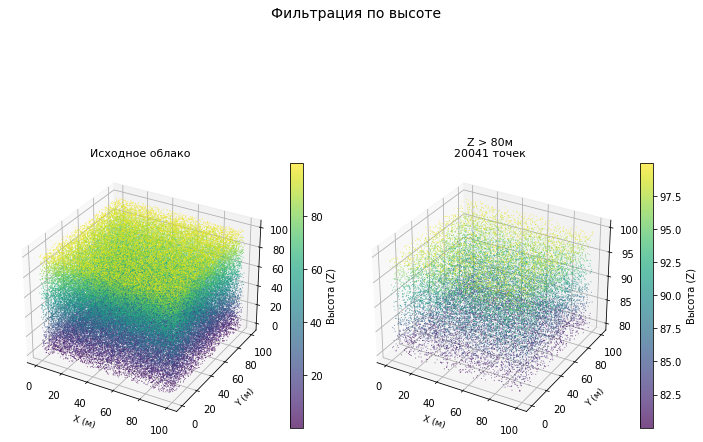


3. Выделение сферической области:
   Точки в сфере R=10м: 424
   Время выполнения: 0.0064 сек


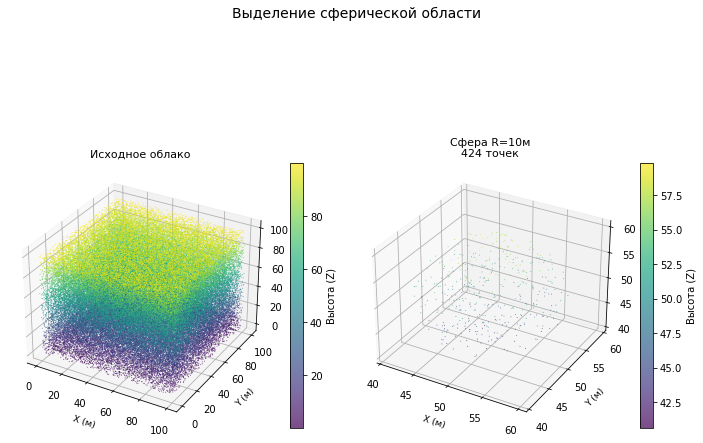


4. Выделение цилиндрической области:
   Точки в цилиндре: 4,244
   Время выполнения: 0.0085 сек


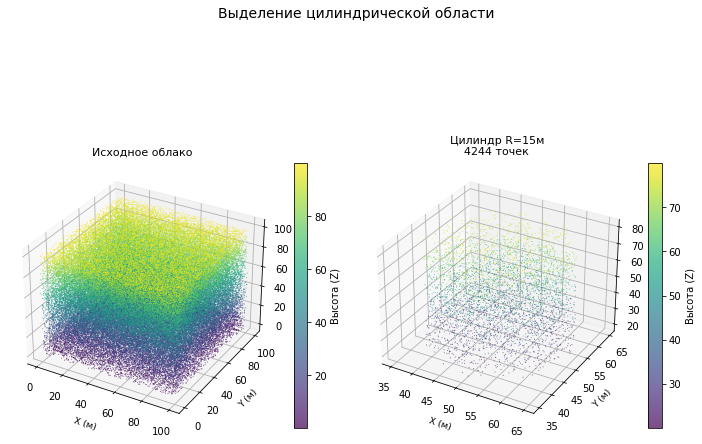


5. Комбинированная фильтрация:
   Точки после комбинированной фильтрации: 1,564
   Время выполнения: 0.0051 сек


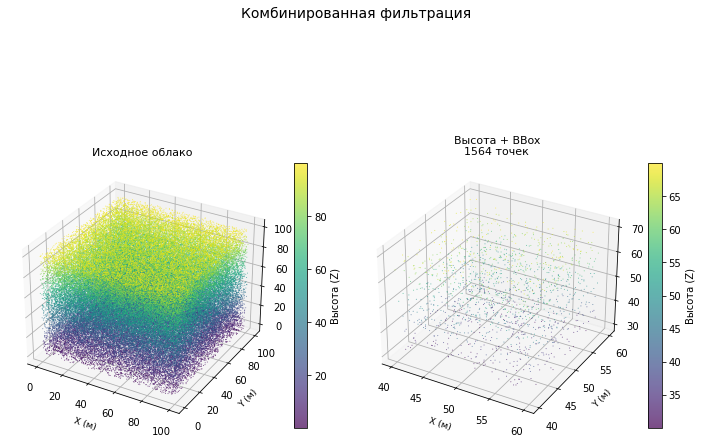


6. Визуализация всех сегментированных областей:


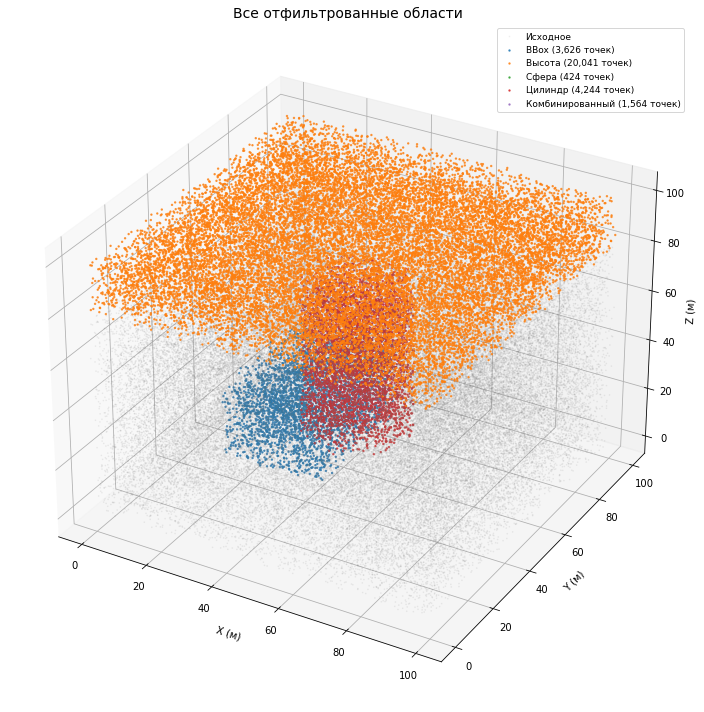


СТАТИСТИКА СЕГМЕНТАЦИИ:
BBox            |    3,626 точек |   3.6% от исходных | 0.0033 сек
Высота          |   20,041 точек |  20.0% от исходных | 0.0024 сек
Сфера           |      424 точек |   0.4% от исходных | 0.0064 сек
Цилиндр         |    4,244 точек |   4.2% от исходных | 0.0085 сек
Комбинированный |    1,564 точек |   1.6% от исходных | 0.0051 сек


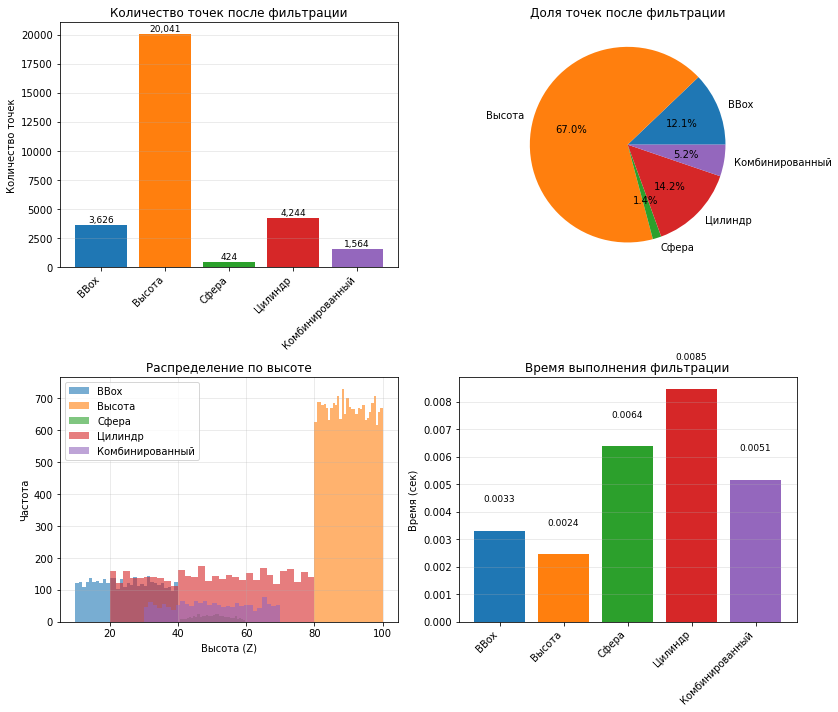


СЕГМЕНТАЦИЯ ЗАВЕРШЕНА
Результаты сохранены в файлы:
  - segmented_bbox.xyz
  - segmented_high.xyz
  - segmented_sphere.xyz
  - segmented_cylinder.xyz
  - segmented_combined.xyz


In [18]:
print("="*60)
print("ДЕМОНСТРАЦИЯ СЕГМЕНТАЦИИ ОБЛАКОВ ТОЧЕК")
print("="*60)

# Инициализация сегментатора и визуализатора
segmenter = CloudSegmenter()
visualizer = CloudVisualizer()

# Генерация или загрузка тестового облака
cloud_file = pathlib.Path("test_point_cloud.xyz")

if cloud_file.exists():
    print("Загрузка существующего облака...")
    point_cloud = np.loadtxt("test_point_cloud.xyz")
else:
    print("Генерация нового тестового облака...")
    point_cloud = segmenter.generate_test_cloud(100000, (0, 100))
    np.savetxt("test_point_cloud.xyz", point_cloud, fmt='%.6f')

print(f"\nИсходное облако содержит: {point_cloud.shape[0]:,} точек")

# Демонстрация различных методов сегментации
results = {}

# 1. Ограничивающий параллелепипед
print("\n1. Сегментация по ограничивающему объему:")
start_time = time.perf_counter()
bbox_region = SpatialRegion(
    x_range=(20, 50),
    y_range=(30, 70),
    z_range=(10, 40)
)
bbox_points = segmenter.extract_bounding_volume(point_cloud, bbox_region)
bbox_time = time.perf_counter() - start_time

np.savetxt("segmented_bbox.xyz", bbox_points, fmt='%.6f')
results['BBox'] = {'points': bbox_points, 'time': bbox_time}
print(f"   Выделено точек: {bbox_points.shape[0]:,}")
print(f"   Время выполнения: {bbox_time:.4f} сек")

visualizer.plot_3d_comparison(
    point_cloud,
    bbox_points,
    "Сегментация по ограничивающему объему",
    "BBox фильтр"
)

# 2. Фильтрация по высоте
print("\n2. Выделение верхних точек:")
start_time = time.perf_counter()
high_points = segmenter.extract_by_elevation(point_cloud, min_z=80)
height_time = time.perf_counter() - start_time

np.savetxt("segmented_high.xyz", high_points, fmt='%.6f')
results['Высота'] = {'points': high_points, 'time': height_time}
print(f"   Точки выше 80м: {high_points.shape[0]:,}")
print(f"   Время выполнения: {height_time:.4f} сек")

visualizer.plot_3d_comparison(
    point_cloud,
    high_points,
    "Фильтрация по высоте",
    "Z > 80м"
)

# 3. Сферическая область
print("\n3. Выделение сферической области:")
start_time = time.perf_counter()
sphere_center = np.array([50, 50, 50])
sphere_radius = 10
spherical_points = segmenter.extract_spherical_region(
    point_cloud, sphere_center, sphere_radius
)
sphere_time = time.perf_counter() - start_time

np.savetxt("segmented_sphere.xyz", spherical_points, fmt='%.6f')
results['Сфера'] = {'points': spherical_points, 'time': sphere_time}
print(f"   Точки в сфере R=10м: {spherical_points.shape[0]:,}")
print(f"   Время выполнения: {sphere_time:.4f} сек")

visualizer.plot_3d_comparison(
    point_cloud,
    spherical_points,
    "Выделение сферической области",
    "Сфера R=10м"
)

# 4. Цилиндрическая область
print("\n4. Выделение цилиндрической области:")
start_time = time.perf_counter()
cylinder_points = segmenter.extract_cylindrical_region(
    point_cloud,
    center=np.array([50, 50]),
    radius=15,
    min_z=20,
    max_z=80
)
cylinder_time = time.perf_counter() - start_time

np.savetxt("segmented_cylinder.xyz", cylinder_points, fmt='%.6f')
results['Цилиндр'] = {'points': cylinder_points, 'time': cylinder_time}
print(f"   Точки в цилиндре: {cylinder_points.shape[0]:,}")
print(f"   Время выполнения: {cylinder_time:.4f} сек")

visualizer.plot_3d_comparison(
    point_cloud,
    cylinder_points,
    "Выделение цилиндрической области",
    "Цилиндр R=15м"
)

# 5. Комбинированная фильтрация
print("\n5. Комбинированная фильтрация:")
start_time = time.perf_counter()

def height_filter(points):
    return segmenter.extract_by_elevation(points, min_z=30, max_z=70)

def bbox_filter(points):
    region = SpatialRegion((40, 60), (40, 60), (0, 100))
    return segmenter.extract_bounding_volume(points, region)

combined_points = segmenter.apply_multiple_filters(
    point_cloud, [height_filter, bbox_filter]
)
combined_time = time.perf_counter() - start_time

np.savetxt("segmented_combined.xyz", combined_points, fmt='%.6f')
results['Комбинированный'] = {'points': combined_points, 'time': combined_time}
print(f"   Точки после комбинированной фильтрации: {combined_points.shape[0]:,}")
print(f"   Время выполнения: {combined_time:.4f} сек")

visualizer.plot_3d_comparison(
    point_cloud,
    combined_points,
    "Комбинированная фильтрация",
    "Высота + BBox"
)

# Визуализация всех областей на одном графике
print("\n6. Визуализация всех сегментированных областей:")
visualizer.plot_filtered_regions(point_cloud, results)

# Визуализация статистики
print("\n" + "="*60)
print("СТАТИСТИКА СЕГМЕНТАЦИИ:")
print("="*60)

for method, data in results.items():
    original_count = point_cloud.shape[0]
    filtered_count = data['points'].shape[0]
    percentage = (filtered_count / original_count) * 100
    print(f"{method:15} | {filtered_count:8,} точек | {percentage:5.1f}% от исходных | {data['time']:.4f} сек")

# Графическая статистика
visualizer.plot_statistics(point_cloud, results)

print("\n" + "="*60)
print("СЕГМЕНТАЦИЯ ЗАВЕРШЕНА")
print("Результаты сохранены в файлы:")
for filename in ["segmented_bbox.xyz", "segmented_high.xyz", 
                 "segmented_sphere.xyz", "segmented_cylinder.xyz", 
                 "segmented_combined.xyz"]:
    print(f"  - {filename}")
print("="*60)